In [2]:
# Note: The codes were originally created by Prof. Jack Baker in the MATLAB

from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import scipy.io as sio
from fn_PSHA_given_M_lambda import fn_PSHA_given_M_lambda
from gmpe_eval import gmpe_eval
from scipy.interpolate import interp1d
import json
import h5py
%matplotlib inline

NameError: name 'matplotlib' is not defined

In [3]:
import matplotlib
print('matplotlib.pyplot: {}'.format(matplotlib.__version__))

matplotlib.pyplot: 3.2.0


In [2]:
x = np.logspace(np.log10(0.001), np.log10(3), 100) # IM values to consider 
IM_label = 'SA(1s)'
gmpeFlag = 2  # use CY2014

# Periods of interest
TFull = list(np.arange(0.01,0.06,step=0.01)) + list(np.arange(0.1,1.025,step=0.025)) + list(np.arange(1.5, 5.25,step=0.25))  
TExample = [0.1, 1, 3]

# Seismicity parameters (strike slip)
rup = {"Fault_Type":1, "Vs30":500, "R":10, "Ztor":0, "delta":90, "rupLambda":0, "Z10":999, "Fhw":0, "FVS30":0, "region":1}

# Plotting parameters
figureAxisLimits = [0.05, max(x), 0.99e-5, 1e-1]
figureXTickVals = [0.05, 0.1, 0.5, 1, 3]


In [3]:
# Point source with G-R magnitudes

# From Table 3.5, \label{tab:grExample_mMax}, fixed rate of M>5, M_max = 8
lambda_M = [0.05, 0.03153, 0.01988, 0.01252, 0.007882, 0.004955, 0.003108, 0.001942, 0.001207, 0.0007432, 0.0004505, 0.0002657, 0.0001492,7.57e-05, 2.93e-05]
M_vals = [5.1, 5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7, 7.9]

In [4]:
# Hazard calcs
x_example = 0.2
UHS_rate = 2.1e-3        # target UHS exceedance rate
UHS_rate_alt = 4.04e-4    # a second target UHS exceedance rate
UHS_rate_alt2 = 0.0139    # a third target UHS exceedance rate
UHSrates = [UHS_rate, UHS_rate_alt, UHS_rate_alt2]

# Codes used to calculate data stored in the UHSdata.json
# lambda0 = []
# UHS = []
# UHS_alt = []
# UHS_alt2 = []
# for i in range(len(TFull)):
#     lambda0_i, _, disagg = fn_PSHA_given_M_lambda(lambda_M, M_vals, TFull[i], x, x_example, rup, gmpeFlag)
#     lambda0.append(lambda0_i)
#     interpF = interp1d(np.log(lambda0[i]["x"]), np.log(x))   # log interpolation
#     UHS.append(np.exp(interpF(np.log(UHS_rate))))
#     UHS_alt.append(np.exp(interpF(np.log(UHS_rate_alt)))) 
#     UHS_alt2.append(np.exp(interpF(np.log(UHS_rate_alt2))))
    
# UHSperiod=TFull
# json_data = {"UHSperiod":UHSperiod, "UHS":UHS, "UHS_alt":UHS_alt, "UHS_alt2":UHS_alt2, "UHSrates":UHSrates}
# with open('UHSdata.json', 'w') as fp:
#     json.dump(json_data, fp, sort_keys=True, indent=4)

with open('./UHSdata.json') as f:
    input_data = json.load(f)
UHSperiod = input_data["UHSperiod"]
UHS = input_data["UHS"]
UHS_alt = input_data["UHS_alt"]
UHS_alt2 = input_data["UHS_alt2"]
UHSrates = input_data["UHSrates"]    

lambdaEx = []
UHSEx = []
UHSEx_alt = []
for i in range(len(TExample)):
    lambdaEx_i, example_output, disagg = fn_PSHA_given_M_lambda(lambda_M, M_vals, TExample[i], x, x_example, rup, gmpeFlag)
    lambdaEx.append(lambdaEx_i)
    interpF = interp1d(np.log(lambdaEx[i]["x"]), np.log(x))   # log interpolation    
    UHSEx.append(np.exp(interpF(np.log(UHS_rate))))
    UHSEx_alt.append(np.exp(interpF(np.log(UHS_rate_alt)))) 


[Text(0, 0, '0.05'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1'),
 Text(0, 0, '3')]

<Figure size 432x288 with 0 Axes>

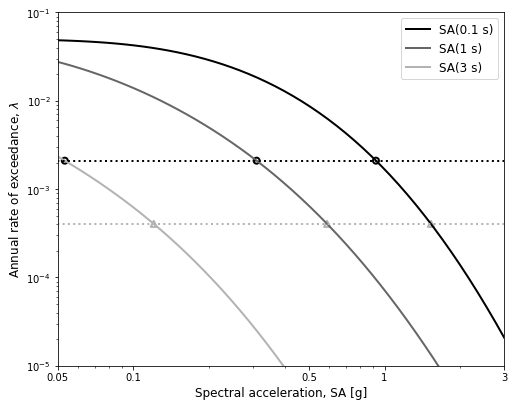

In [5]:
# Plot Fig 7.11: hazard curve
colorSpec = [0, 0.4, 0.7]
plt.figure(1)
fig, ax = plt.subplots(figsize=(8, 6.5))
legendText = []
for i in range(len(TExample)):
    legendText.append("SA(" + str(TExample[i]) + " s)") 
    ax.plot(x, lambdaEx[i]["x"], linewidth=2, color=list(colorSpec[i]*np.array([1, 1, 1])), label=legendText[i])

ax.plot([0.001, 10], list(UHS_rate*np.array([1, 1])), ':k', linewidth=2)
ax.plot([0.001, 10], list(UHS_rate_alt*np.array([1, 1])), ':k', linewidth=2, color=[0.7, 0.7, 0.7])
ax.scatter(UHSEx, list(UHS_rate*np.ones(len(TExample))), facecolors='none', edgecolor='k', linewidth=2)
ax.scatter(UHSEx_alt, list(UHS_rate_alt*np.ones(len(TExample))), marker='^', facecolors='none', edgecolor=[0.7, 0.7, 0.7], linewidth=2)

ax.set_xlabel('Spectral acceleration, SA [g]', fontsize = 12)
ax.set_ylabel('Annual rate of exceedance, $\lambda$', fontsize = 12)
ax.set_ylim(1e-5, 1e-1)
ax.set_xlim(0.05, 3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='upper right', fontsize=12)
ax.set_xticks(figureXTickVals)
ax.set_xticklabels(figureXTickVals)


[Text(0, 0, '0'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1'),
 Text(0, 0, '1.5'),
 Text(0, 0, '2')]

<Figure size 432x288 with 0 Axes>

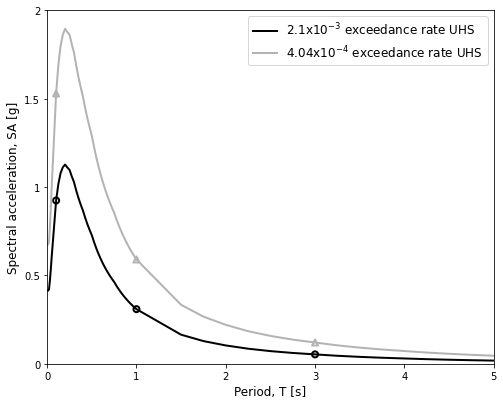

In [6]:
# Plot Fig 7.12: UHS
plt.figure(2)
fig, ax = plt.subplots(figsize=(8, 6.5))
ax.plot(TFull, UHS, '-k', linewidth=2, label='2.1x$10^{-3}$ exceedance rate UHS')
ax.plot(TFull, UHS_alt, linewidth=2, color=[0.7, 0.7, 0.7], label='4.04x$10^{-4}$ exceedance rate UHS')
ax.scatter(TExample, UHSEx, facecolors='none', edgecolor='k', linewidth=2)
ax.scatter(TExample, UHSEx_alt, marker='^', facecolors='none', edgecolor=[0.7, 0.7, 0.7], linewidth=2)

ax.set_xlabel('Period, T [s]', fontsize = 12)
ax.set_ylabel('Spectral acceleration, SA [g]', fontsize = 12)
ax.set_ylim(0, 2)
ax.set_xlim(0, 5)
ax.legend(loc='upper right', fontsize=12)
ax.set_yticks([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0, 0.5, 1, 1.5, 2])


For SA(0.1 s), $\bar{M}$ = 5.9, $\bar{\varepsilon}$ = 1.9
For SA(3 s), $\bar{M}$ = 6.5, $\bar{\varepsilon}$ = 1.2


<Figure size 432x288 with 0 Axes>

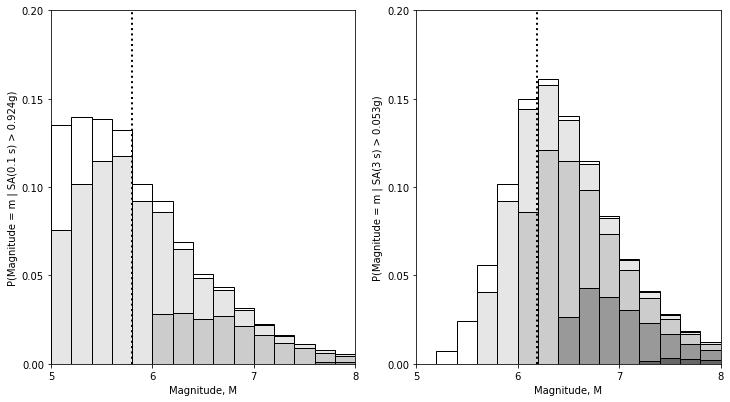

In [7]:
# Plot Fig 7.13: disaggs
disaggIdx = [0, 2]  # indices of example periods to perform disaggration at
n_cols = math.ceil(len(disaggIdx)/2)
plt.figure(3)
fig, subplots = plt.subplots(n_cols, 2, figsize=(12,6.5*n_cols))
c = ['0', '0.2', '0.4', '0.6', '0.8', '0.9', '1']
example_output = list(np.zeros(max(disaggIdx) + 1))
disaggUHS = list(np.zeros(max(disaggIdx) + 1))
i = 0
for ax in subplots:
    if i < len(disaggIdx):
        idx = disaggIdx[i]
        x_example = UHSEx[idx]  # example values for table
        lambda0, example_output[idx], disaggUHS[idx] = fn_PSHA_given_M_lambda(lambda_M, M_vals, TExample[idx], x, x_example, rup, gmpeFlag)

        for j in range(disaggUHS[idx]["M_Eps"].shape[1]):
            bottom=np.sum(disaggUHS[idx]["M_Eps"][:,0:j], axis=1)
            ax.bar(M_vals, disaggUHS[idx]["M_Eps"][:,j], bottom=bottom, width=0.2, edgecolor = 'k', color=c[j])
        meanM = np.sum(np.array(M_vals) * np.array(disaggUHS[idx]["equal"]))
        ax.plot([meanM, meanM], [0, 1], ':k', linewidth=2) # plot mean magnitude   
        ax.set_xlabel("Magnitude, M")  
        ax.set_ylabel("P(Magnitude = m | " + legendText[idx] + " > " + str(format(x_example,".3f")) + "g)")
        ax.set_xlim(5, 8)
        ax.set_ylim(0, 0.2)
        ax.set_yticks(np.arange(0, 0.25, step = 0.05))
        ax.set_xticks(np.arange(5, 9, step = 1))  
        optext = "For " + legendText[idx] + ', ' + r"$\bar{M}$ = " + str(format(disaggUHS[idx]["Mbar"],".1f")) + ', ' + r"$\bar{\varepsilon}$ = " + str(format(disaggUHS[idx]["epsBar"],".1f"))
        print(optext)
    i += 1


<Figure size 432x288 with 0 Axes>

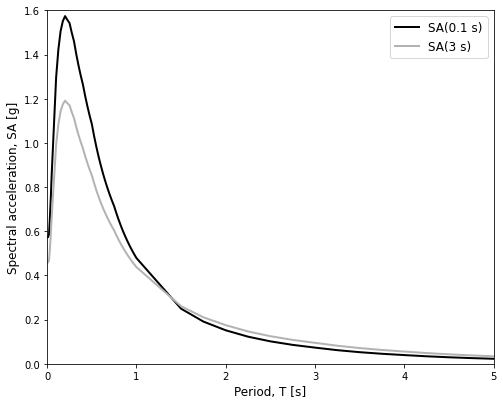

In [8]:
# Plot Fig 7.14: spectra associated with disaggs
plt.figure(4)
fig, ax = plt.subplots(figsize=(8, 6.5))
c = ['0', '0.7']
sa = np.zeros((len(disaggIdx),len(TFull)))
sigma = np.zeros((len(disaggIdx),len(TFull)))
for i in range(len(disaggIdx)):
    idx = disaggIdx[i]
    for j in range(len(TFull)):
        sa[i][j], sigma[i][j] = gmpe_eval(TFull[j], disaggUHS[idx]["Mbar"], rup, gmpeFlag)
    ax.plot(TFull, np.exp(np.log(sa[i])+disaggUHS[idx]["epsBar"]*sigma[i]), linewidth=2, color=c[i], label=legendText[disaggIdx[i]])
    
ax.set_xlabel('Period, T [s]', fontsize = 12)
ax.set_ylabel('Spectral acceleration, SA [g]', fontsize = 12)
ax.set_ylim(0, 1.6)
ax.set_xlim(0, 5)
ax.legend(loc='upper right', fontsize=12)


In [9]:
# Superimpose actual records on the UHS

# load NGA-West2 data
hf = h5py.File('NGA_W2_meta_data.h5', 'r')
Sa_RotD50 = np.array(hf.get('Sa_RotD50'))
magnitude = np.array(hf.get('magnitude'))
closest_D = np.array(hf.get('closest_D'))
Periods = np.array(hf.get('Periods'))
soil_Vs30 = np.array(hf.get('soil_Vs30'))

criteria = {"min_M":5.6, "max_M":6.2, "min_R":5, "max_R":15, "min_Vs30":400, "max_Vs30":600}

acceptable = ((magnitude >= criteria["min_M"]) & (magnitude <= criteria["max_M"]) & (closest_D >= criteria["min_R"]) \
              & (closest_D <= criteria["max_R"]) & (soil_Vs30 >= criteria["min_Vs30"]) &  (soil_Vs30 <= criteria["max_Vs30"]))

numRecs = np.sum(acceptable)

Sa_RotD50_use = Sa_RotD50[acceptable,:]

<ipython-input-9-1a90647c2a02>:30: RuntimeWarning: invalid value encountered in greater_equal
  & (closest_D <= criteria["max_R"]) & (soil_Vs30 >= criteria["min_Vs30"]) &  (soil_Vs30 <= criteria["max_Vs30"]))
<ipython-input-9-1a90647c2a02>:30: RuntimeWarning: invalid value encountered in less_equal
  & (closest_D <= criteria["max_R"]) & (soil_Vs30 >= criteria["min_Vs30"]) &  (soil_Vs30 <= criteria["max_Vs30"]))


([<matplotlib.axis.YTick at 0x7fcd3ef60f70>,
 <a list of 5 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

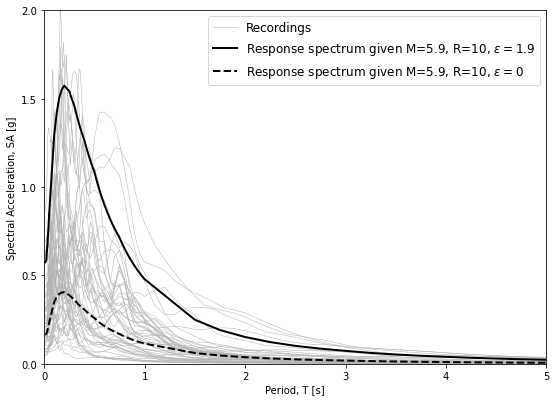

In [10]:
# Plot Fig 7.15
plt.figure(4)
plt.figure(figsize=(9, 6.5))
for i in range(len(Sa_RotD50_use)-1):
    plt.plot(Periods, Sa_RotD50_use[i], linewidth=0.5, color=[0.7, 0.7, 0.7])
plt.plot(Periods, Sa_RotD50_use[-1], linewidth=0.5, color=[0.7, 0.7, 0.7], label="Recordings")
idx = disaggIdx[0]
plt.plot(TFull, np.exp(np.log(sa[0])+disaggUHS[idx]["epsBar"]*sigma[0]), '-k', linewidth=2, label=r"Response spectrum given M=5.9, R=10, $\varepsilon=1.9$")
plt.plot(TFull, sa[0], '--k', linewidth=2, label=r"Response spectrum given M=5.9, R=10, $\varepsilon=0$")
plt.xlabel('Period, T [s]')
plt.ylabel('Spectral Acceleration, SA [g]')
plt.legend(loc='upper right', fontsize=12)
plt.xlim(0, 5)
plt.ylim(0, 2)
plt.yticks(np.arange(0, 2.5, step = 0.5))


In [11]:
# Associated tabular data

# probabilities of exceedance
summaryOutput = np.around(np.transpose(example_output[disaggIdx[0]][0:4] + [example_output[disaggIdx[1]][3]]), decimals=4)
np.set_printoptions(suppress=True, precision=4)
print(summaryOutput)

# kernel of the PSHA term
summaryOutput2 = np.array(example_output[disaggIdx[0]][0:3] + [example_output[disaggIdx[0]][4]] + [example_output[disaggIdx[1]][4]])


[[ 0.      5.1     0.0185  0.0145  0.0003]
 [ 1.      5.3     0.0117  0.026   0.0016]
 [ 2.      5.5     0.0074  0.0405  0.0077]
 [ 3.      5.7     0.0046  0.0579  0.0281]
 [ 4.      5.9     0.0029  0.0779  0.0769]
 [ 5.      6.1     0.0018  0.1004  0.1617]
 [ 6.      6.3     0.0012  0.1252  0.2746]
 [ 7.      6.5     0.0007  0.152   0.3972]
 [ 8.      6.7     0.0005  0.1905  0.5128]
 [ 9.      6.9     0.0003  0.2296  0.6108]
 [10.      7.1     0.0002  0.2677  0.6898]
 [11.      7.3     0.0001  0.3038  0.7522]
 [12.      7.5     0.0001  0.3376  0.8014]
 [13.      7.7     0.      0.37    0.8404]
 [14.      7.9     0.      0.4005  0.8714]]
